<a href="https://colab.research.google.com/github/enzocatorano/deep_learning_practicas/blob/master/7_AEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo FICH: Autocodificadores

El objetivo de este práctico es que puedan implmentar diferentes arquitecturas de autocodificadores y sus métodos de entrenamiento.

In [ ]:
# Imports básicos
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch as tr
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## FashionMNIST Dataset

Fashion-MNIST es un dataset compilado por una empresa de tecnología en ventas de accesorios de moda. Es un dataset simple, que sigue el mismo espíritu del MNIST de dígitos, pero con un poco más de riqueza en los datos. Tiene 60,000 ejemplos en la particion de entrenamiento y 10,000 en la de test. Cada ejemplo es una imagen de un canal de 28x28, con una etiqueta asociada de 10 clases disponibles.



100%|██████████| 26421880/26421880 [00:03<00:00, 8490882.11it/s] 


Extracting mnist-data/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist-data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 142745.49it/s]


Extracting mnist-data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2665499.75it/s]


Extracting mnist-data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18841428.44it/s]


Extracting mnist-data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/FashionMNIST/raw



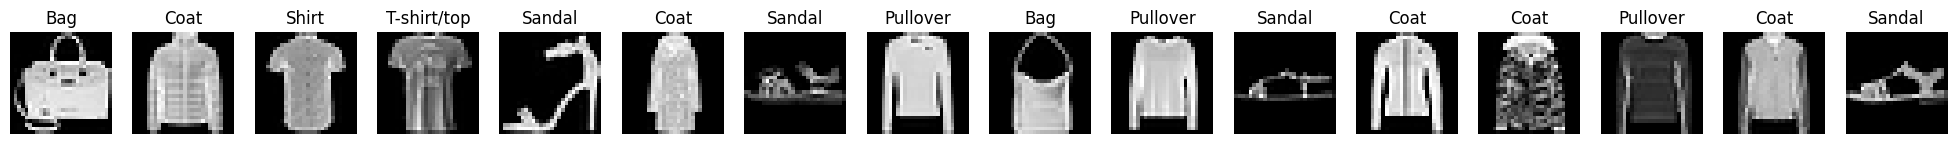

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST("mnist-data", train=True,
                   transform=transforms.ToTensor(), download=True)

Lt = int(len(train_data)*.8)
data_classes = train_data.classes
train_data, valid_data = random_split(train_data, [Lt, len(train_data) - Lt])

test_data = FashionMNIST("mnist-data", train=False,
                  transform=transforms.ToTensor(), download=True)
IM_SIZE = (28, 28)

# Dataloaders (para recorrer el dataset y armar lotes)
nbatch = 256
train_loader = DataLoader(train_data, batch_size=nbatch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=nbatch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=False)

# Ejemplos de train
nfig = min(16, nbatch)
for x, y in train_loader:
    fig, ax = plt.subplots(1, nfig, figsize=(25, 5))
    for k in range(nfig):
        ax[k].imshow(x[k,:,:].squeeze().numpy(), cmap="gray")
        ax[k].set_title(f"{data_classes[y[k].item()]}")
        ax[k].axis("off")
    break # solo un batch

## Implementación de base

Implementar un autocodificador basico y lo entrenamos con este dataset. ¿Da resultados razonables?

In [ ]:
from torch import nn
import torch as tr

class AE(nn.Module):
    def __init__(self, emb_size, imsize=[28, 28], device='cpu'):
        super().__init__()

        nin = imsize[0]*imsize[1]
        self.encoder = nn.Sequential(nn.Linear(nin, emb_size),
                                     nn.Sigmoid())

        self.decoder = nn.Sequential(nn.Linear(emb_size, nin),
                                     nn.Sigmoid()) # los píxeles van entre 0 y 1

        self.loss_func = nn.MSELoss()
        self.optim = tr.optim.Adam(self.parameters(), lr=1e-3)
        self.device = device
        self.to(device)
        self.imsize = imsize

    def encode(self, x):
        x = x.view(x.shape[0], -1)
        z = self.encoder(x)
        return z

    def decode(self, z):
        xhat = self.decoder(z)
        xhat = xhat.view(xhat.shape[0], 1, self.imsize[0], self.imsize[1])
        return xhat

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        return xhat

    def fit(self, loader, verbose=False):
        """Función de entrenamiento (una época). En este caso no usamos las
        etiquetas (y) sino que buscamos reconstruir la misma entrada x"""
        epoch_loss = 0
        if verbose:
            loader = tqdm(loader)
        for x, _ in loader:
            x = x.to(self.device)

            self.optim.zero_grad()
            xhat = self(x)
            loss = self.loss_func(xhat, x)
            epoch_loss += loss.item()
            loss.backward()
            self.optim.step()

        return epoch_loss/len(loader)


    def test(self, loader):
        """Función de evaluación (una época)"""
        epoch_loss = 0
        ref, pred = [], []
        for x, _ in loader:
            with tr.no_grad():
                x = x.to(self.device)
                xhat = self(x)

            loss = self.loss_func(xhat, x)
            epoch_loss += loss.item()

        return epoch_loss/len(loader)

net = AE(emb_size=32)
net

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (loss_func): MSELoss()
)

## Entrenamiento

In [ ]:
import time

EMB_SIZE = 32
DEVICE = "cuda" # o "cpu"

net = AE(emb_size=EMB_SIZE, device=DEVICE)
print(net)
log = []
best_loss, counter, patience = 999, 0, 3
for epoch in range(10):
    t0 = time.time()
    train_loss = net.fit(train_loader, verbose=False)
    valid_loss = net.test(valid_loader)

    if valid_loss < best_loss:
        best_loss = valid_loss
        tr.save(net.state_dict(), 'model.pmt')
        counter = 0
    else:
        counter += 1
        if counter > patience:
            break

    print(f'Epoch {epoch}, train_loss {train_loss:.3f}, val_loss {valid_loss:.3f} ({time.time()-t0:.2f} s)')
    log.append([train_loss, valid_loss])


AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (loss_func): MSELoss()
)
Epoch 0, train_loss 0.094, val_loss 0.071 (12.19 s)
Epoch 1, train_loss 0.063, val_loss 0.057 (8.92 s)
Epoch 2, train_loss 0.052, val_loss 0.048 (7.96 s)
Epoch 3, train_loss 0.045, val_loss 0.042 (8.66 s)
Epoch 4, train_loss 0.039, val_loss 0.037 (8.68 s)
Epoch 5, train_loss 0.035, val_loss 0.034 (7.87 s)
Epoch 6, train_loss 0.032, val_loss 0.031 (8.48 s)
Epoch 7, train_loss 0.030, val_loss 0.029 (8.48 s)
Epoch 8, train_loss 0.028, val_loss 0.027 (9.83 s)
Epoch 9, train_loss 0.026, val_loss 0.026 (8.01 s)


## Calidad de reconstrucción
Podemos ver la calidad de reconstruccion comparando $x$ y $\hat{x}$:

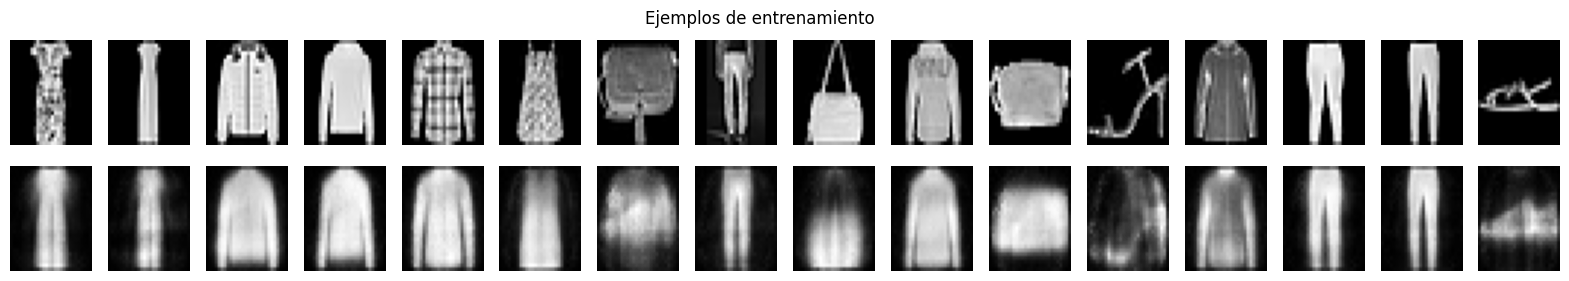

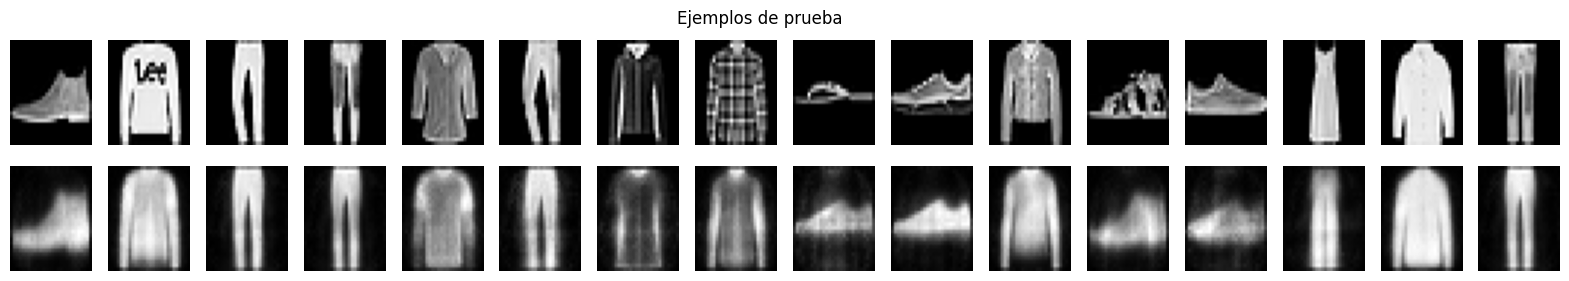

In [ ]:
for x, _ in train_loader:
    x_hat = net(x.to(DEVICE)).detach()
    fig, ax = plt.subplots(2, min(16, nbatch), figsize=(20, 3))
    for k in range(min(16, nbatch)):
        ax[0, k].imshow(x[k,:,:].squeeze(), aspect="auto", cmap="gray")
        ax[0, k].axis("off")

        ax[1, k].imshow(x_hat[k,:].squeeze().cpu(), aspect="auto", cmap="gray")
        ax[1, k].axis("off")
    break # solo un batch
fig.suptitle("Ejemplos de entrenamiento")



fig, ax = plt.subplots(2, min(16, nbatch), figsize=(20, 3))
for x, _ in test_loader:
    x_hat = net(x.to(DEVICE)).detach()

    for k in range(min(16, nbatch)):
        ax[0, k].imshow(x[k, :, :].squeeze(), aspect="auto", cmap="gray")
        ax[0, k].axis("off")

        ax[1, k].imshow(x_hat[k, :, :].squeeze().cpu(), aspect="auto", cmap="gray")
        ax[1, k].axis("off")

    break # solo un batch
fig.suptitle("Ejemplos de prueba");



## Exploración del espacio latente
Además de la calidad de reconstrucción, ¿que podemos decir del espacio latente para este dataset? Es importante verificar qué esta pasando en las representaciones de la red, más aun en aplicaciones de aprendizaje no supervisado, donde no tenemos tanta información si lo que "entiende" la red es correcto. Recordemos que el objetivo no es que la red aprenda a copiar datos, sino que aprenda las variables subyacentes y que estas variables representen correctamente el espacio de los datos.

Para esto usaremos los datos de test, que no fueron vistos por el modelo.

**Lo que sigue puede unos cuantos minutos con el test set completo**, limitamos el análisis a los primeros N ejemplos

In [ ]:
N = 100

# Representación en Z para cada ejemplo
z_test = np.zeros((min(N, len(test_data)), EMB_SIZE), dtype=float)
# y su etiqueta
labels_test = np.zeros(min(N, len(test_data)), dtype=int)

k = 0
for x, y in test_loader:  # batch
    for b in range(x.shape[0]):  # elemento
        if k >= N:
            break
        z = np.array(net.encode(x[b, :, :].to(DEVICE)).detach().squeeze().cpu())
        z_test[k, :] = z
        labels_test[k] = int(y[b].squeeze())
        k += 1


Podemos usar diferentes técnicas para visualizar. Un método útil (que también se usa para reducir dimensionalidad) es el UMAP. El objetivo es representar los puntos de Z en un espacio 2D.

(También podríamos hacer esto con un autoencoder con dim(Z) = 2)


In [ ]:
!pip install umap-learn

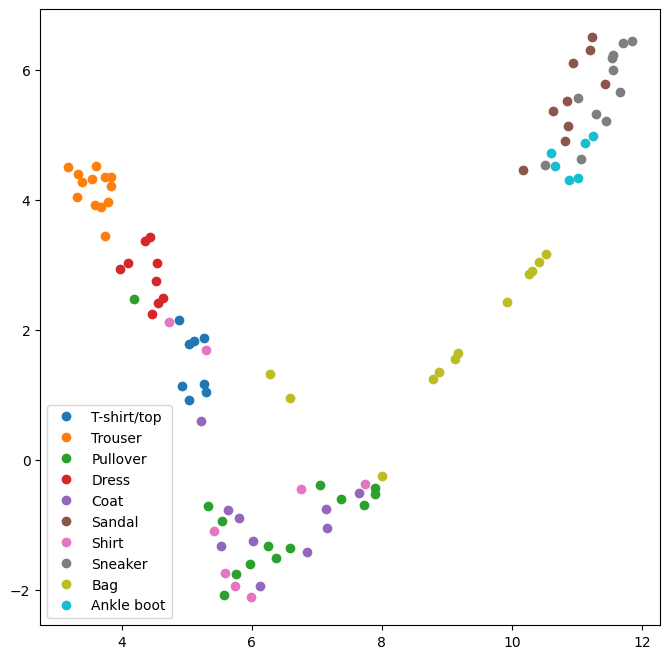

In [ ]:
from umap import UMAP

umap_2d = UMAP(n_components=2)

samples_2d = umap_2d.fit_transform(z_test)

plt.figure(figsize=(8, 8))
for k, l in enumerate(np.unique(labels_test)):
    label_ind = labels_test == l
    plt.plot(samples_2d[label_ind, 0], samples_2d[label_ind, 1], "o",
             label=data_classes[l])

plt.legend();

A partir del análisis de representaciones uno puede verificar que el modelo este funcionando bien en general, y luego identificar ejemplos raros o mal etiquetados

## Entregable

Para el entregable deberán:

1. Explorar como mejorar los resultados haciendo cambios en la arquitectura, el tamaño del espacio latente, tasa de aprendizaje, etc. Evaluar al menos dos valores para cada variable.

2. Modificar PixelAE para implementar un autocodificador por eliminación de ruido. Para esto deberán agregar ruido (haciendo cero algunos pixeles o agregando ruido gaussiano) a la entrada durante el entrenamiento y validación.Pueden usar la función de la siguiente celda. Luego corroborar que puede eliminar el ruido en imágenes de test, comparar con diferentes relaciones de señal/ruido en entrenamiento y en test.

**Ejercicio opcional:**
La arquitectura del autocodificador es bien general y se pueden usar diferentes tipos de capas diferenciables. Con lo visto en las clases anteriores, reemplazar las capas densas por capas convolucionales (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Tener en cuenta que el decodificador requiere la operación pseudo-inversa para volver a la escala de la imagen original (https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). Discutir el resultado respecto al autocodificador denso en términos de calidad de la representación y cantidad de parámetros

### Agregando ruido
Para hacer el DAE se puede usar un agregado de ruido como el siguiente

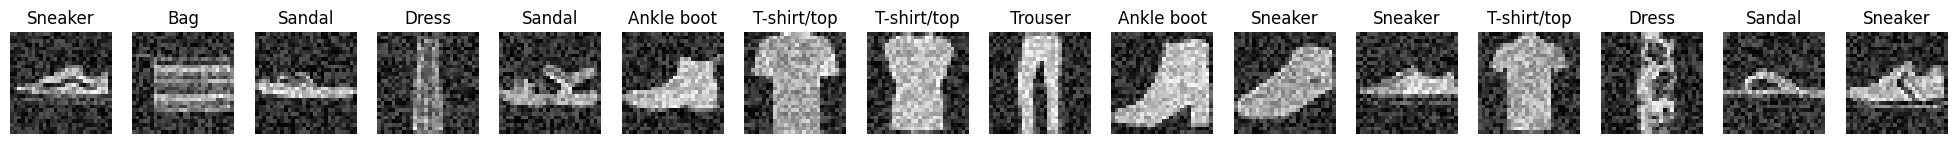

In [ ]:
NOISE_FACTOR = .5

# Ejemplos de train
for x, y in train_loader:
    fig, ax = plt.subplots(1, min(16, nbatch), figsize=(25, 5))
    for k in range(min(16, nbatch)):
        im = x[k,:,:] + NOISE_FACTOR * tr.rand(x[k,:,:].shape)
        ax[k].imshow(im.squeeze(), cmap="gray")
        ax[k].set_title(f"{data_classes[y[k].item()]}")
        ax[k].axis("off")
    break # solo un batch

## Robustez de la representación al ruido
En este ejemplo, usamos el mismo AE entrenado previamente para evaluar su capacidad de reconstrucción en contexto ruidoso. Como da este resultado con un DAE?

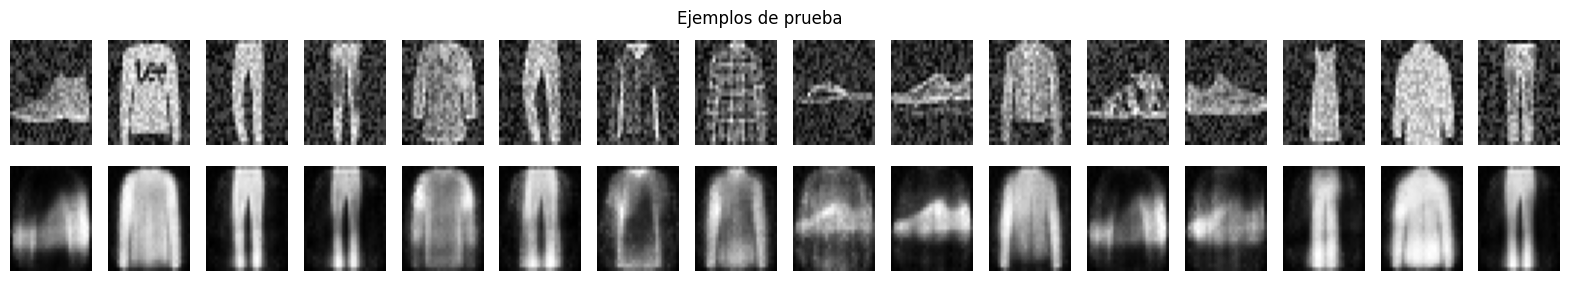

In [ ]:
fig, ax = plt.subplots(2, min(16, nbatch), figsize=(20, 3))
for x, _ in test_loader:

    x = x + .5 * tr.rand(x.shape)
    x_hat = net(x.to(DEVICE)).detach()

    for k in range(min(16, nbatch)):
        ax[0, k].imshow(x[k, :, :].squeeze(), aspect="auto", cmap="gray")
        ax[0, k].axis("off")

        ax[1, k].imshow(x_hat[k, :, :].squeeze().cpu(), aspect="auto", cmap="gray")
        ax[1, k].axis("off")
    break # solo un batch
fig.suptitle("Ejemplos de prueba");